# Image Classification with MNIST Using a Petastorm Dataset and PyTorch

In this notebook we will read a training dataset saved in the Petastorm format in the project's feature store and use that to train a Deep CNN defined in PyTorch to classify images of digits in the MNIST dataset.

This notebook assumes that you have already created the training datasets in the feature store, which you can do by running this notebook: 

[Create Petastorm MNIST Dataset Notebook](PetastormMNIST_CreateDataset.ipynb)

![Petastorm 7](./../images/petastorm7.png "Petastorm 7")

In [1]:
from hops import hdfs, featurestore, experiment, tensorboard
import numpy as np
import pydoop
import json

# Must import pyarrow before torch. See: https://github.com/uber/petastorm/blob/master/docs/troubleshoot.rst
import pyarrow as pa
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from petastorm import make_reader, TransformSpec
from petastorm.tf_utils import make_petastorm_dataset
from petastorm.pytorch import DataLoader

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1559565096638_0007,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


## Constants

In [2]:
TRAIN_DATASET_NAME = "MNIST_train_petastorm"
TEST_DATASET_NAME = "MNIST_test_petastorm"
BATCH_SIZE = 50
NUM_EPOCHS = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.001
SEED = 1
LOG_INTERVAL = 10
READER_EPOCHS = 1
PROJECT_PATH = hdfs.project_path()

## Step 1: Define The Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Step 2: Define PyTorch Dataset Transformer

Petastorm datasets can be read directly with PyTorch by using `make_reader` and `make_petastorm_dataset` from the Petastorm library

In [15]:
def _transform_row(mnist_row):
    """
    Normalize images
    """
    transform = transforms.Compose([
        transforms.Lambda(lambda nd: nd.reshape(28, 28, 1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    # In addition, the petastorm pytorch DataLoader does not distinguish the notion of
    # data or target transform, but that actually gives the user more flexibility
    # to make the desired partial transform, as shown here.
    result_row = {
        'image': transform(mnist_row['image']),
        'digit': mnist_row['digit']
    }

    return result_row

## Step 3: Define Epoch Reader and Training Loop

In [16]:
def train_epoch(train_dataset_path, model, device, optimizer, epoch):
    """
    Function for training a single epoch of MNIST using PyTorch
    """
    with DataLoader(make_reader(train_dataset_path, num_epochs=READER_EPOCHS, hdfs_driver='libhdfs',
                               transform_spec=TransformSpec(_transform_row)), 
                    batch_size=BATCH_SIZE) as train_loader:
        correct = 0
        count = 0
        train_loss = 0
        model.train()
        for batch_idx, row in enumerate(train_loader):
            data, target = row['image'].to(device), row['digit'].to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            train_loss += loss.item()
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += data.shape[0]
            loss.backward()
            optimizer.step()
            if batch_idx % LOG_INTERVAL == 0:
                print('Train Epoch: {} [{}]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), loss.item()))
        train_accuracy = correct / count
        train_loss /= count
        return train_accuracy, train_loss, epoch

## Step 4: Put it All Together in a Training Function

In [17]:
def train_fn():
    """
    The training loop
    """
    # Setup Torch
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(SEED)
    device = torch.device('cuda' if use_cuda else 'cpu')
    # Create Model
    model = Net().to(device)
    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    # get dataset path from the featurestore
    train_dataset_path = featurestore.get_training_dataset_path(TRAIN_DATASET_NAME)
    train_history = {}
    train_epochs = []
    train_accuracies = []
    train_losses = []
    for epoch in range(1, NUM_EPOCHS + 1):
        train_accuracy, train_loss, epoch = train_epoch(train_dataset_path, model, device, optimizer, epoch)
        train_epochs.append(epoch)
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
    torch.save(model.state_dict(), "mnist_torch_ps.pt") #PyTorch can't save to HDFS in the current version so save to local fs first
    hdfs.copy_to_hdfs("mnist_torch_ps.pt", hdfs.project_path() + "mnist/", overwrite=True) # copy from local fs to hdfs
    train_history["acc"] = train_accuracies
    train_history["epoch"] = train_epochs
    train_history["loss"] = train_losses
    # save training history to HDFS
    results_path = hdfs.project_path() + "mnist/mnist_train_results_2.txt"
    hdfs.dump(json.dumps(train_history), results_path)
    return train_history

## Step 5: Training Experiments


In [18]:
train_history = train_fn()

Train Epoch: 1 [0]	Loss: 2.314652
Train Epoch: 1 [500]	Loss: 2.347810
Train Epoch: 1 [1000]	Loss: 2.322586
Train Epoch: 1 [1500]	Loss: 2.292396
Train Epoch: 1 [2000]	Loss: 2.293021
Train Epoch: 1 [2500]	Loss: 2.279352
Train Epoch: 1 [3000]	Loss: 2.323452
Train Epoch: 1 [3500]	Loss: 2.277730
Train Epoch: 1 [4000]	Loss: 2.245240
Train Epoch: 1 [4500]	Loss: 2.224981
Train Epoch: 1 [5000]	Loss: 2.203325
Train Epoch: 1 [5500]	Loss: 2.202740
Train Epoch: 1 [6000]	Loss: 2.194582
Train Epoch: 1 [6500]	Loss: 2.204894
Train Epoch: 1 [7000]	Loss: 2.185442
Train Epoch: 1 [7500]	Loss: 2.105492
Train Epoch: 1 [8000]	Loss: 2.085393
Train Epoch: 1 [8500]	Loss: 2.058237
Train Epoch: 1 [9000]	Loss: 1.887053
Train Epoch: 1 [9500]	Loss: 1.932784
Train Epoch: 1 [10000]	Loss: 1.965014
Train Epoch: 1 [10500]	Loss: 1.860895
Train Epoch: 1 [11000]	Loss: 1.852554
Train Epoch: 1 [11500]	Loss: 1.784856
Train Epoch: 1 [12000]	Loss: 1.768502
Train Epoch: 1 [12500]	Loss: 1.804160
Train Epoch: 1 [13000]	Loss: 1.60531

## Step 6: Plot Training Results

Inside the `train_fn` function we saved the training history to HDFS, which means we can later read it in %%local mode for plotting.

In [19]:
%%local
import json
from hops import hdfs
import matplotlib.pyplot as plt
from pylab import rcParams
results_path = hdfs.project_path() + "mnist/mnist_train_results_2.txt"
results = json.loads(hdfs.load(results_path))

### Plot Loss/Epoch During Training

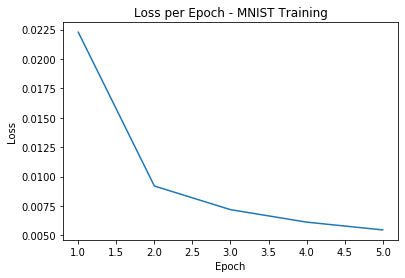

In [20]:
%%local
%matplotlib inline
y = results["loss"] #loss
x = list(range(1, len(y)+1))#epoch
plt.title("Loss per Epoch - MNIST Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)

### Plot Accuracy/Epoch During Training

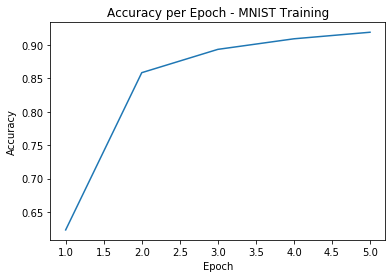

In [21]:
%%local
%matplotlib inline
y = results["acc"] #acc
x = list(range(1, len(y)+1))#epoch
plt.title("Accuracy per Epoch - MNIST Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(x,y)

## Step 7: Evaluation Using Trained Model and Test Dataset

Inside the train_fn function we saved the trained model to HDFS in the ps format. We can load the weights of this model and use for serving predictions or for evaluation, in this example we will evaluate the model against the test set. 

### Load Model Weights

In [22]:
model_path_hdfs = hdfs.project_path() + "mnist/" + "mnist_torch_ps.pt"

Currently PyTorch HDFS support is limited. To get around this we can download the ps model in the local file system and load it from there using `torch.load`. 

In [23]:
local_path = hdfs.copy_to_local(model_path_hdfs)

File hdfs://10.0.2.15:8020/Projects/demo_featurestore_admin000/mnist/mnist_torch_ps.pt is already localized, skipping download...

In [24]:
model = Net()
model.load_state_dict(torch.load(local_path))

In [25]:
def test_epoch(test_dataset_path, model, device, epoch):
    """
    Function for testing a single epoch of MNIST test dataset using PyTorch
    """
    with DataLoader(make_reader(test_dataset_path, num_epochs=READER_EPOCHS, hdfs_driver='libhdfs',
                               transform_spec=TransformSpec(_transform_row)), 
                    batch_size=BATCH_SIZE) as test_loader:
        model.eval()
        test_loss = 0
        correct = 0
        count = 0
        with torch.no_grad():
            for row in test_loader:
                data, target = row['image'].to(device), row['digit'].to(device)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                count += data.shape[0]

        test_loss /= count
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, count, 100. * correct / count))

In [26]:
def test_fn(model):
    # Setup Torch
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(SEED)
    device = torch.device('cuda' if use_cuda else 'cpu')
    # get dataset path from the featurestore
    test_dataset_path = featurestore.get_training_dataset_path(TEST_DATASET_NAME)
    for epoch in range(1, NUM_EPOCHS + 1):
        test_epoch(test_dataset_path, model, device, epoch)

In [27]:
test_fn(model)


Test set: Average loss: 0.0953, Accuracy: 9689/10000 (97%)


Test set: Average loss: 0.0953, Accuracy: 9689/10000 (97%)


Test set: Average loss: 0.0953, Accuracy: 9689/10000 (97%)


Test set: Average loss: 0.0953, Accuracy: 9689/10000 (97%)


Test set: Average loss: 0.0953, Accuracy: 9689/10000 (97%)